# Dynamic Aperture
*This notebook will soon be refactored into a single SciBmad function for general usage*

Thanks to SciBmad's support for both explicit Single Instruction, Multiple Data (SIMD) on the CPU and Single Instruction, Multiple Thread (SIMT) on the GPU, highly-parallelized and performant tracking simulations can be run on all types of architectures. Here we will do a dynamic aperture scan of the v6.3.1 Electron Storage Ring (ESR) of the Electron-Ion Collider (EIC).

In [1]:
using Revise
using SciBmad, CairoMakie, DelimitedFiles
using Optim # Optimization package
using GTPSA
GTPSA.show_eps=1e-13; # hide tiny monomials

Precompiling packages...
   1092.3 ms  ✓ BeamTracking → BeamTrackingBeamlinesExt
  48163.3 ms  ✓ SciBmad
  2 dependencies successfully precompiled in 50 seconds. 110 already precompiled.


In [2]:
include("../../lattices/esr-v6.3.1.jl");

In [3]:
# 2nd order Yoshida for performance
foreach(t->t.tracking_method=Yoshida(order=2), ring.line)

# Twiss:
tw = twiss(ring)

# Tunes:
tw.tunes

3-element StaticArraysCore.SVector{3, TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=1)
 Index Coefficient                Order   Exponent
--------------------------------------------------------------------
   1:   7.9999998080113530e-02      0      0   0   0   0   0   0
--------------------------------------------------------------------
   2:   1.4000000380498639e-01      0      0   0   0   0   0   0
--------------------------------------------------------------------
   3:  -2.3344227124645025e+00      1      0   0   0   0   0   1


In [4]:
# Need to turn on RF cavities
# Add a knob for each cavity voltage
# Put it in a module to stay organized
module Controls end
Controls.voltage = 1e6

cavities = filter(x->x.kind=="RFCavity", ring.line)
println(map(x->x.name, cavities))

# Make cavities controlled by variable `voltage`
foreach(x->x.voltage=DefExpr(()->Controls.voltage), cavities)
tw=twiss(ring; at=[])
tw.tunes

["RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0", "RF0"]


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  0.07999999808006483
  0.14000000380494165
 -0.02721612703466663

In [5]:
# Use AD to make the synchrotron tune -0.05

# Define function to return objective function (F) AND 
# gradient (G) IF PROVIDED:
function f_and_grad!(F, G, u, p)
    # p is a tuple storing constant parameters and desired Qs
    ring = p[1]
    control_mod = p[2]
    weight = p[3]
    Qs_goal = p[4]

    if G !== nothing
        # 6 variables to 2nd order, 1 parameter to 1st order
        drf = Descriptor(6, 2, 1, 1)
        Δk = params(drf)[1]
        control_mod.voltage = u[1] + Δk
        tw = twiss(ring; GTPSA_descriptor=drf, at=[]) # at no elements, only tunes
        Qs = scalar(tw.tunes[3])
        dQs_dV = tw.tunes[3][param=1]
        G .= 2*weight^2*dQs_dV*(Qs-Qs_goal)

        if F !== nothing
            return abs2(weight*(Qs-Qs_goal))
        end
    elseif F !== nothing # Just compute Qs, no derivative 
        control_mod.voltage = u[1]
        tw = twiss(ring; at=[]) # at no elements, only tunes
        Qs = scalar(tw.tunes[3])
        return abs2(weight*(Qs-Qs_goal))
    end
end

# Optimize using Optim.jl
u0 = [2e6] # initial guess
p = (ring, Controls, 1e7, -0.05)

# Define closure with parameters
# Use Optim.NLSolversBase.only_fg! to specify f_and_gradient provided:
f = Optim.NLSolversBase.only_fg!((F,G,u)->f_and_grad!(F,G,u,p))

# Optimize
sol = Optim.optimize(f, u0, GradientDescent())

 * Status: success

 * Candidate solution
    Final objective value:     2.608171e-15

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 2.30e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.84e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.97e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.14e+11 ≰ 0.0e+00
    |g(x)|                 = 7.67e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    4
    f(x) calls:    13
    ∇f(x) calls:   13


In [6]:
GTPSA.show_eps=1e-10

1.0e-10

In [7]:
# Set control variable with solution
Controls.voltage = sol.minimizer[1]

3.3556067906993786e6

In [9]:
# Check the tunes:
tw = twiss(ring; GTPSA_descriptor=Descriptor(6,2), at=[])
tw.tunes

3-element StaticArraysCore.SVector{3, TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=2)
 Index Coefficient                Order   Exponent
--------------------------------------------------------------------
   1:   7.9999998080146476e-02      0      0   0   0   0   0   0
--------------------------------------------------------------------
   2:   1.4000000380501595e-01      0      0   0   0   0   0   0
--------------------------------------------------------------------
   3:  -5.0000000000005110e-02      0      0   0   0   0   0   0


In [55]:
tw.table

In [47]:
tw = twiss(ring)
t = tw.table
println(t.slip[end])
Controls.voltage=0
twiss(ring).tunes[3]

-2.2825290412537216


TPS64{GTPSA.Dynamic}:
Descriptor(NV=6, MO=1)
 Coefficient                Order   Exponent
 -2.3344227124645025e+00      1      0   0   0   0   0   1


In [49]:
Descriptor(6,2,1,2)
Controls.voltage += params()[1]
twiss(ring; GTPSA_descriptor=Descriptor(6,2,1,2)).tunes[3]

TPS64{GTPSA.Dynamic}:
Descriptor(NV=6, MO=2, NP=1, PO=2)
 Coefficient                Order   Exponent
 -2.3344227124645025e+00      1      0   0   0   0   0   1   |   0
  6.3498093517044314e+00      2      1   1   0   0   0   0   |   0
  6.3569327416266015e+00      2      0   0   1   1   0   0   |   0
 -2.1711159383949363e+00      2      0   0   0   0   0   2   |   0


[0.07172282593436612, 0.14941331943430922, -0.04420382704330032]


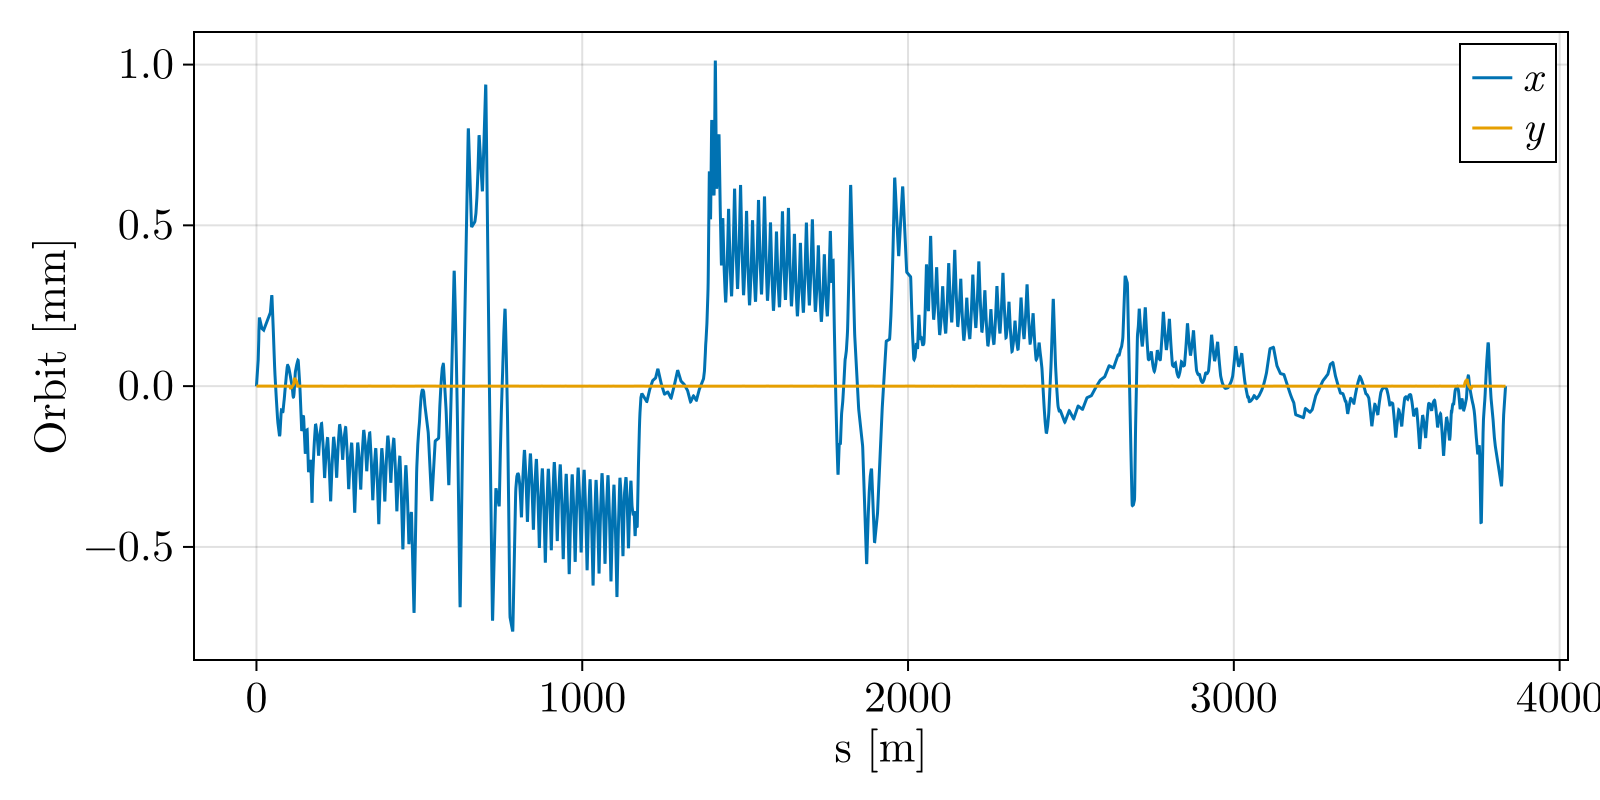

In [9]:
# Great! Now let's turn on radiation damping

foreach(t->t.tracking_method=Yoshida(order=2, radiation_damping_on=true), ring.line)
tw = twiss(ring)

# Check tunes:
println(tw.tunes)

t = tw.table

# Plot the orbit:
set_theme!(theme_latexfonts())

fig = Figure(fontsize=22, size=(800,400));
ax = Axis(fig[1, 1], xlabel="s [m]", ylabel="Orbit [mm]");
lines!(ax, t.s, t.orbit_x.*10^3, label=L"x"); 
lines!(ax, t.s, t.orbit_y.*10^3, label=L"y");
axislegend(position=:rt);
display(fig);

In [10]:
# Now let's do DA scan. we will track a bunch and see what happens
# Using numbers from previous DA studies:
emit_a = 30e-9
emit_b = 15e-9       # Very conservative...
emit_c = 7.30474E-06 # From Bmad/PTC

7.30474e-6

In [14]:
# To compute sig_x, need to convert eigenemittances to moments
# Use de moivre:
twd = twiss(ring; de_moivre=true, at=[ring.line[1]]);

In [15]:
# Now compute sigmas at first element (IP)
E = twd.table.E[1]
sig_x = sqrt(E[1][1,1]*emit_a + E[2][1,1]*emit_b + E[3][1,1]*emit_c)
sig_y = sqrt(E[1][3,3]*emit_a + E[2][3,3]*emit_b + E[3][3,3]*emit_c)
sig_x, sig_y

(0.0001333874822532964, 2.8886274739896483e-5)

In [16]:
# Create polar grid distribution for various deltas
# Initialize matrix of particles:
n_r = 30
n_theta = 65
deltas = (0:0.1:1).*10^-2 # 0.1-1% delta
max_sig_x = 15
max_sig_y = 22

thetas = range(0, pi, length=n_theta)
rs = range(0, 1, length=n_r)[2:end]

N_particles = length(deltas)*(1+length(rs)*length(thetas))
println("N_particles = $N_particles")
v0 = zeros(N_particles, 6)
idx_particle = 1
for delta in deltas
    v0[idx_particle,:] = [0, 0, 0, 0, 0, delta]
    idx_particle += 1
    for theta in thetas
        for r in rs
            x_grid = max_sig_x * r * cos(theta)
            y_grid = max_sig_y * r * sin(theta)
            x = x_grid * sig_x
            y = y_grid * sig_y
            v0[idx_particle,:] = [x, 0, y, 0, 0, delta]
            idx_particle += 1
        end
    end
end

# These coordinates are in closed orbit basis, need to put in integration frame
co =  [twd.table.orbit_x[1], twd.table.orbit_px[1], twd.table.orbit_y[1], twd.table.orbit_py[1], twd.table.orbit_z[1], twd.table.orbit_pz[1]]
v = zeros(N_particles, 6)
for i in 1:N_particles
    v[i,:] = co + v0[i,:]
end

b0 = Bunch(v)

N_particles = 20746


Bunch{Float64, Float64, BeamTracking.Coords{Vector{UInt8}, Matrix{Float64}, Nothing}}(Species(Null), NaN, 0.0, BeamTracking.Coords{Vector{UInt8}, Matrix{Float64}, Nothing}(UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01  …  0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01], [-2.600068605012088e-7 1.5303928131355438e-5 … -0.027043835425205835 -0.00035227176406044493; 6.873351844292797e-5 1.5303928131355438e-5 … -0.027043835425205835 -0.00035227176406044493; … ; -0.0019320787153565184 1.5303928131355438e-5 … -0.027043835425205835 0.009647728235939557; -0.0020010722406599473 1.5303928131355438e-5 … -0.027043835425205835 0.009647728235939557], nothing))

In [17]:
# Now track, without radiation fluctuations
#foreach(t->t.tracking_method=Yoshida(order=2, radiation_damping_on=true, radiation_fluctuations_on=true), ring.line)
#@time begin
N_turns = 2000
for i in 1:N_turns
    print("\r Tracking turn: $i")
    flush(stdout) 
    track!(b0, ring)
end
writedlm("state.dlm", b0.coords.state)
writedlm("v.dlm", b0.coords.v)
println()
#end

 Tracking turn: 1Setting bunch.species = Species(electron, charge=-1.0e, mass=510998.95069 eV/c², spin=0.5ħ) (reference species from the Beamline)
Setting bunch.R_ref = -59.5287244902766 (reference R_ref from the Beamline)
 Tracking turn: 2000


In [36]:
# each column is a DA line
x_norm_da = zeros(length(thetas), length(deltas))
y_norm_da = zeros(length(thetas), length(deltas))

# Loop thru the thetas, find max for each along r
idx_particle = 1
for i in 1:length(deltas)
    if b0.coords.state[idx_particle] != 0x1
            println("dead on co, delta = $(deltas[i])")
        idx_particle += length(thetas)*length(rs)
        continue
    end
    idx_particle += 1
    for j in 1:length(thetas)
        # Sanity check:
        x = v0[idx_particle:idx_particle+length(rs)-1,1]./(max_sig_x.*sig_x)
        y = v0[idx_particle:idx_particle+length(rs)-1,3]./(max_sig_y.*sig_y)
        for idx in 1:length(x)
            xi = x[idx]
            yi = y[idx] 
            if !(atan(yi,xi) ≈ thetas[j])
                error("Something went wrong")
            end
        end
        
        idx_da = idx_particle-1 + findfirst(t->t != 0x1, b0.coords.state[idx_particle:idx_particle+length(rs)-1])
        
        # Sanity check:
        if idx_da-(idx_particle-1) != 1 && b0.coords.state[idx_da-1] != 0x1
            error("Something went wrong")
        end
        
        x_norm_da[j,i] = v0[idx_da,1]/sig_x
        y_norm_da[j,i] = v0[idx_da,3]/sig_y
        idx_particle += length(rs)
    end
end

dead on co, delta = 0.008000000000000002
dead on co, delta = 0.009000000000000003
dead on co, delta = 0.010000000000000002


In [33]:
length(deltas)

11

In [29]:
x_norm_da[:,9]

65-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

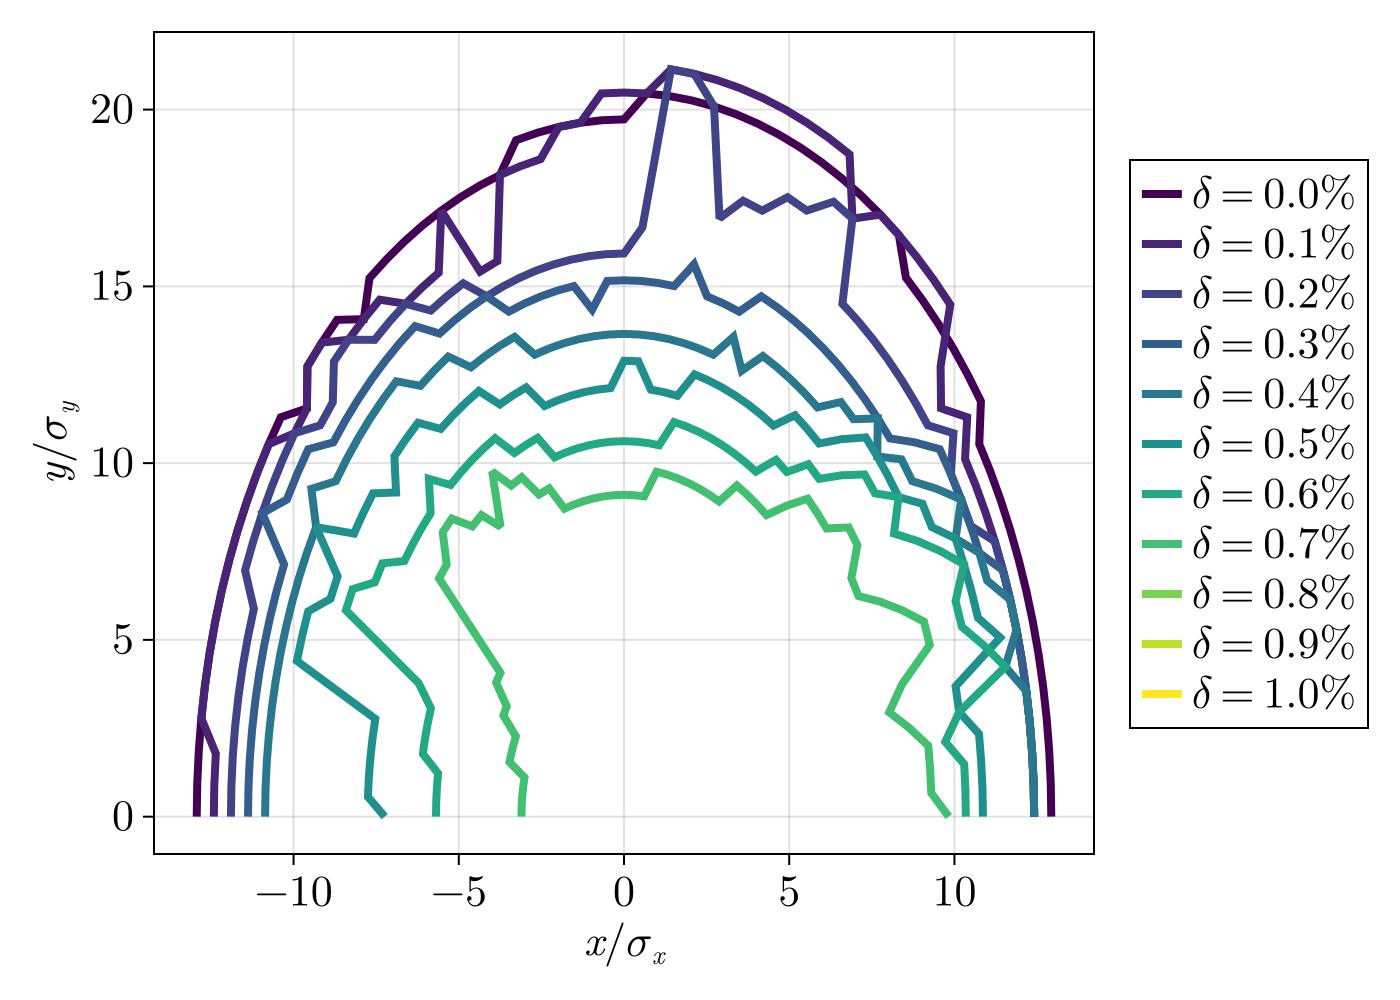

In [20]:
f2 = Figure(fontsize=22, size=(700,500));
ax = Axis(f2[1, 1], xlabel=L"x/\sigma_x", ylabel=L"y/\sigma_y")#, limits=(-15,15,0,22))

for i in 1:length(deltas)
    lines!(x_norm_da[:,i], y_norm_da[:,i], linewidth=4, color=i, colorrange=(1,11), label=L"\delta=%$(round(deltas[i]*10^2; sigdigits=1))\%")
end
f2[1,2] = Legend(f2, ax)
display(f2);

In [330]:
using Statistics
mask = findall(t->t==0x1, b0.coords.state)
avg_x = mean(b0.coords.v[mask,1])
avg_px = mean(b0.coords.v[mask,2])
avg_x2 = mean((b0.coords.v[mask,1].-avg_x).^2)
avg_px2 = mean((b0.coords.v[mask,2].-avg_px).^2)
avg_xpx = mean((b0.coords.v[mask,1].-avg_x).*(b0.coords.v[mask,2].-avg_px))
sqrt(avg_x2*avg_px2 - avg_xpx^2)*10^9

35.4036676688456

In [331]:
avg_y = mean(b0.coords.v[mask,3])
avg_py = mean(b0.coords.v[mask,4])
avg_y2 = mean((b0.coords.v[mask,3].-avg_y).^2)
avg_py2 = mean((b0.coords.v[mask,4].-avg_py).^2)
avg_ypy = mean((b0.coords.v[mask,3].-avg_y).*(b0.coords.v[mask,4].-avg_py))
sqrt(avg_y2*avg_py2 - avg_ypy^2)*10^9

4.990393082372988